## Libraries

In [ ]:
!pip install openai-clip datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha256=eccde17d68d337cb400e2f3adf7c49937d6f48e20e38ecd5194884133b428307
  Stored in directory: /root/.cache/pip/wheels/08/77/8e/8d2f862df6bf7fb4e2007062d2cbaeae49862ec7b56d041229
Successfully built openai-clip


In [ ]:
import clip
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
from google.colab import files
import skimage.io as io
import requests

import json
import string, os, re, pickle
import pandas as pd
from PIL import Image
from io import StringIO
from datasets import Dataset

from torch.utils.data import DataLoader
from transformers import CLIPProcessor, CLIPModel, CLIPVisionConfig

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load testing dataset

In [ ]:
image_path = "/content/drive/MyDrive/datasets/pokemon_hf_png"
caption_path = "/content/drive/MyDrive/datasets/pokemon_caption_hf.csv"

In [ ]:
imagename_df = pd.DataFrame(os.listdir(image_path))
imagename_df.columns = ['filename']
imagename_df['pokedex'] = imagename_df['filename'].str.replace('.png', "")
imagename_df['filename'] = imagename_df['filename'].transform(lambda x: image_path + "/" + x)

caption_df = pd.read_csv(caption_path)
caption_df['pokedex'] = caption_df['pokedex'].astype(str)
caption_df.drop(caption_df.columns[[0]],axis=1,inplace=True)

dataset_df = imagename_df.merge(caption_df, how='left', on='pokedex')
dataset_df = dataset_df[['filename', 'caption']].rename(columns={"caption": "text", "filename": "image"})
dataset_df.head()

,image,text
0,/content/drive/MyDrive/datasets/pokemon_hf_png...,a red and white ball with an angry look on its...
1,/content/drive/MyDrive/datasets/pokemon_hf_png...,a drawing of a green pokemon with red eyes
2,/content/drive/MyDrive/datasets/pokemon_hf_png...,a bunch of balls with faces drawn on them
3,/content/drive/MyDrive/datasets/pokemon_hf_png...,a cartoon character with a potted plant on his...
4,/content/drive/MyDrive/datasets/pokemon_hf_png...,a green and yellow toy with a red nose


In [ ]:
def gen():
    for index, row in dataset_df.iterrows():
      yield {"text":row["text"], "image":Image.open(row['image'])}
dataset = Dataset.from_generator(gen).shuffle(seed=123)
dataset = dataset.train_test_split(test_size=0.1, shuffle = False)

Generating train split: 0 examples [00:00, ? examples/s]

## Functions for text generation

In [ ]:
class MLP(nn.Module):
    def forward(self, x):
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):
    def get_dummy_token(self, batch_size, device):
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens, prefix, mask = None, labels = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length, prefix_size = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))

def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():
        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):
                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

 ## Load fine-tuned model and predict

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
prefix_length = 10

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
prefix_length = 10

model = ClipCaptionModel(prefix_length)

os.system("gdown https://drive.google.com/uc?id=14pXWwB4Zm82rsDdvbGguLfx9F8aM7ovT")
altered_state_dict = torch.load('conceptual_weights.pt', map_location=torch.device('cpu'))
for i in range(12):
    del altered_state_dict['gpt.transformer.h.' + str(i) + '.attn.bias']
    del altered_state_dict['gpt.transformer.h.' + str(i) + '.attn.masked_bias']
model.load_state_dict(altered_state_dict)

model = model.eval()
model = model.to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
clip_model_trained, preprocess_trained = clip.load("ViT-B/32", device=device, jit=False)

checkpoint = torch.load(f"/content/drive/MyDrive/Pretrained Models/clip_easy_9.pt")
clip_model_trained.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
generated_captions = []
prefix_traineds = []
print(len(dataset["test"]))

# prepare image for the model
for i, example in enumerate(dataset["test"]):
  print(i)
  pil_image = example["image"]
  image_trained = preprocess_trained(pil_image).unsqueeze(0).to(device)
  with torch.no_grad():
      prefix_trained = clip_model_trained.encode_image(image_trained).to(device, dtype=torch.float32)
      prefix_traineds.append(prefix_trained)
      prefix_embed = model.clip_project(prefix_trained).reshape(1, prefix_length, -1)

  generated_caption = generate2(model, tokenizer, embed=prefix_embed)
  print(generated_caption)
  generated_captions.append(generated_caption)

84
0


100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


the sun is the light of the soul.
1


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


film character from the movie.
2


100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


digital art selected for the #.
3


100%|██████████| 1/1 [00:00<00:00,  7.66it/s]


the world is a gift to you.
4


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


animal and person are the cutest dogs in the world.
5


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


this is what i want my dog to look like.
6


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


i'm not sure what this is, but i love the idea of a spider and a bat.
7


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


the art of the dragon.
8


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


the eyes of the vector art illustration.
9


100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


the most interesting person in the world.
10


100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


butterfly with a heart - shaped face.
11


100%|██████████| 1/1 [00:00<00:00, 13.97it/s]


the art of the fox.
12


100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


the tree of life is the fruit of deity.
13


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


i'm not a fan of the figurines, but i love the art style.
14


100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


digital art selected for the #.
15


100%|██████████| 1/1 [00:00<00:00, 13.72it/s]


the dragon in the mirror.
16


100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


the art of person, by person.
17


100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


the most interesting halloween costumes.
18


100%|██████████| 1/1 [00:00<00:00, 12.60it/s]


the power of the red ribbon.
19


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


i'm not a big fan of pink, but i love the idea of a cat with a heart.
20


100%|██████████| 1/1 [00:00<00:00, 14.74it/s]


the eyes of the dragon.
21


100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


person is a purple person with a purple mane.
22


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


duck with a baby... i'm not sure what kind of bird this is.
23


100%|██████████| 1/1 [00:00<00:00,  9.61it/s]


the man with the world in his hands.
24


100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

the red dragon is a symbol of strength and strength.
25



100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


the little guy in the red dress.
26


100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


digital art selected for the #.
27


100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


digital art selected for the #.
28


100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


the most beautiful birds in the world.
29


100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


digital art selected for the #.
30


100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


person is a professional boxer who has competed.
31


100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


this is the most interesting dinosaur in the world.
32


100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


the art of drawing with a pencil.
33


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


film character from the animated series.
34


100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


the blue and the orange are the same color.
35


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


the most interesting man in the world.
36


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


the red dragon and the red dragon are the main characters of the game.
37


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


i'm not sure what this rabbit is doing with his ears, but i love the idea of it.
38


100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


the flower in the middle.
39


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


the art of drawing with a pencil.
40


100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


person is a professional boxer and currently a member.
41


100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


the art of the chicken.
42


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


i'm not a pink person, but i'm pretty sure i'm gon na get a pink nose.
43


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


this is the face of a red fox.
44


100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


the red dragon is the most popular dragon in the world.
45


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


the red dragon is a symbol of love.
46


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


this is the most important part of my body.
47


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


i'm not a fan of the white fur on the nose, but i love the idea of a white cat with a white face.
48


100%|██████████| 1/1 [00:00<00:00,  6.49it/s]


i'm not a dog, but i'm a man.
49


100%|██████████| 1/1 [00:00<00:00,  6.60it/s]


the wolf and the lion are two of my favorite things.
50


100%|██████████| 1/1 [00:00<00:00, 12.51it/s]


the art of the red dragon.
51


100%|██████████| 1/1 [00:00<00:00, 14.93it/s]


film character and the rabbit.
52


100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


the art of drawing with a pencil.
53


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


i'm not a big fan of dogs, but i love the idea of a dog giving a heart to a cat.
54


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


i'm not sure what this is, but i love the idea of a face.
55


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


this is the face of a dog.
56


100%|██████████| 1/1 [00:00<00:00,  7.25it/s]


this is a picture of a black and white mouse.
57


100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


the art of the fox.
58


100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


this is a flower that i made for my daughter.
59


100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


digital art selected for the #.
60


100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


digital art selected for the #.
61


100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


the most interesting cat in the meme.
62


100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


the art of the flower.
63


100%|██████████| 1/1 [00:00<00:00,  6.55it/s]


the dragon and the dragonfly are two of my favorite things.
64


100%|██████████| 1/1 [00:00<00:00,  9.61it/s]


the world's most popular cartoon characters.
65


100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


the art of the flower.
66


100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


the face of a monster.
67


100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


digital art selected for the #.
68


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


i'm not a big fan of the blue eyes, but i love the blue one.
69


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


i'm not sure what this is, but it's a cute idea.
70


100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


the frog is the symbol of wisdom.
71


100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


the art of drawing with a pencil.
72


100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


the dragon is the symbol of love.
73


100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


this is a picture of a man with a piggy back.
74


100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


the dragon is the symbol of the new year.
75


100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


the most beautiful birds in the world.
76


100%|██████████| 1/1 [00:00<00:00, 13.52it/s]


the face of a monster.
77


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


i'm not sure what this is, but it's a smile.
78


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


i'm not sure what this is, but i love the black and pink.
79


100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


the dragon is the most powerful animal in the universe.
80


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


i'm not sure what kind of dog this is, but i love the idea of a panda with a cat.
81


100%|██████████| 1/1 [00:00<00:00,  9.61it/s]


person is a talented illustrator and designer.
82


100%|██████████| 1/1 [00:00<00:00, 13.52it/s]


film character from the movie.
83


100%|██████████| 1/1 [00:00<00:00, 10.92it/s]

digital art selected for the #.


In [ ]:
generated_captions

['the sun is the light of the soul.',
 'film character from the movie.',
 'digital art selected for the #.',
 'the world is a gift to you.',
 'animal and person are the cutest dogs in the world.',
 'this is what i want my dog to look like.',
 "i'm not sure what this is, but i love the idea of a spider and a bat.",
 'the art of the dragon.',
 'the eyes of the vector art illustration.',
 'the most interesting person in the world.',
 'butterfly with a heart - shaped face.',
 'the art of the fox.',
 'the tree of life is the fruit of deity.',
 "i'm not a fan of the figurines, but i love the art style.",
 'digital art selected for the #.',
 'the dragon in the mirror.',
 'the art of person, by person.',
 'the most interesting halloween costumes.',
 'the power of the red ribbon.',
 "i'm not a big fan of pink, but i love the idea of a cat with a heart.",
 'the eyes of the dragon.',
 'person is a purple person with a purple mane.',
 "duck with a baby... i'm not sure what kind of bird this is.",


In [ ]:
save_array = []
for i, example in enumerate(dataset["test"]):
  save_array.append([example["text"], generated_captions[i]])
save_array

dataframe = pd.DataFrame(save_array)
dataframe.to_csv("/content/drive/MyDrive/result/clip_easy_10.csv")

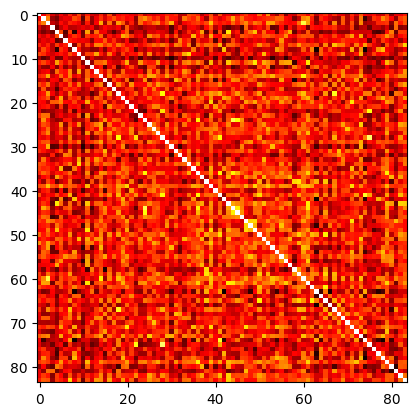

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

arrays = []
for i in prefix_traineds:
  arrays.append(i.cpu().data.numpy()[0])

heatmapdata = cosine_similarity(arrays)

plt.imshow(heatmapdata, cmap='hot')
plt.show()

In [ ]:
heatmapdata

array([[0.99999976, 0.67787546, 0.731632  , ..., 0.6715135 , 0.6754605 ,
        0.70080435],
       [0.67787546, 1.0000004 , 0.778267  , ..., 0.60002625, 0.72725767,
        0.7508173 ],
       [0.731632  , 0.778267  , 1.0000002 , ..., 0.7665559 , 0.69923747,
        0.7438871 ],
       ...,
       [0.6715135 , 0.60002625, 0.7665559 , ..., 0.9999999 , 0.67031795,
        0.6363001 ],
       [0.6754605 , 0.72725767, 0.69923747, ..., 0.67031795, 0.99999964,
        0.7686666 ],
       [0.70080435, 0.7508173 , 0.7438871 , ..., 0.6363001 , 0.7686666 ,
        1.        ]], dtype=float32)